## Why deply a machine Learning Model ?

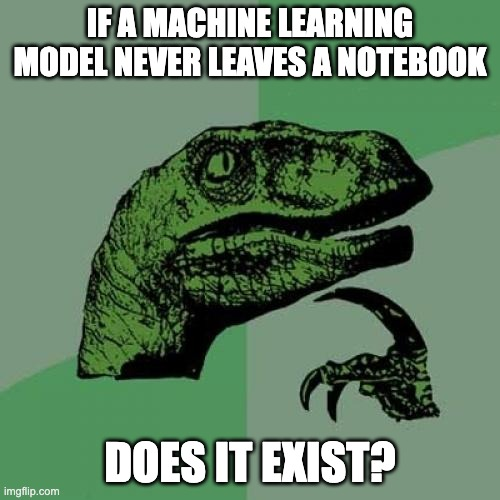


Deploying a model is as important as a training one
1. Although you can get a pretty good idea of how your models going to function by evaluating it on a crafted test set or visualizing its results you never really know how its going to perform until you release it to wild(production)
2. Lets take our food vision mini  model? what if some one puts their dog image as the input then what would happen are we going to classify thier dog? we have to consider all of these while 
putting our model into production

* Thus this highlights the importance of model deployment: it helps you figure out errors in your model that aren't obvious during training/testing.

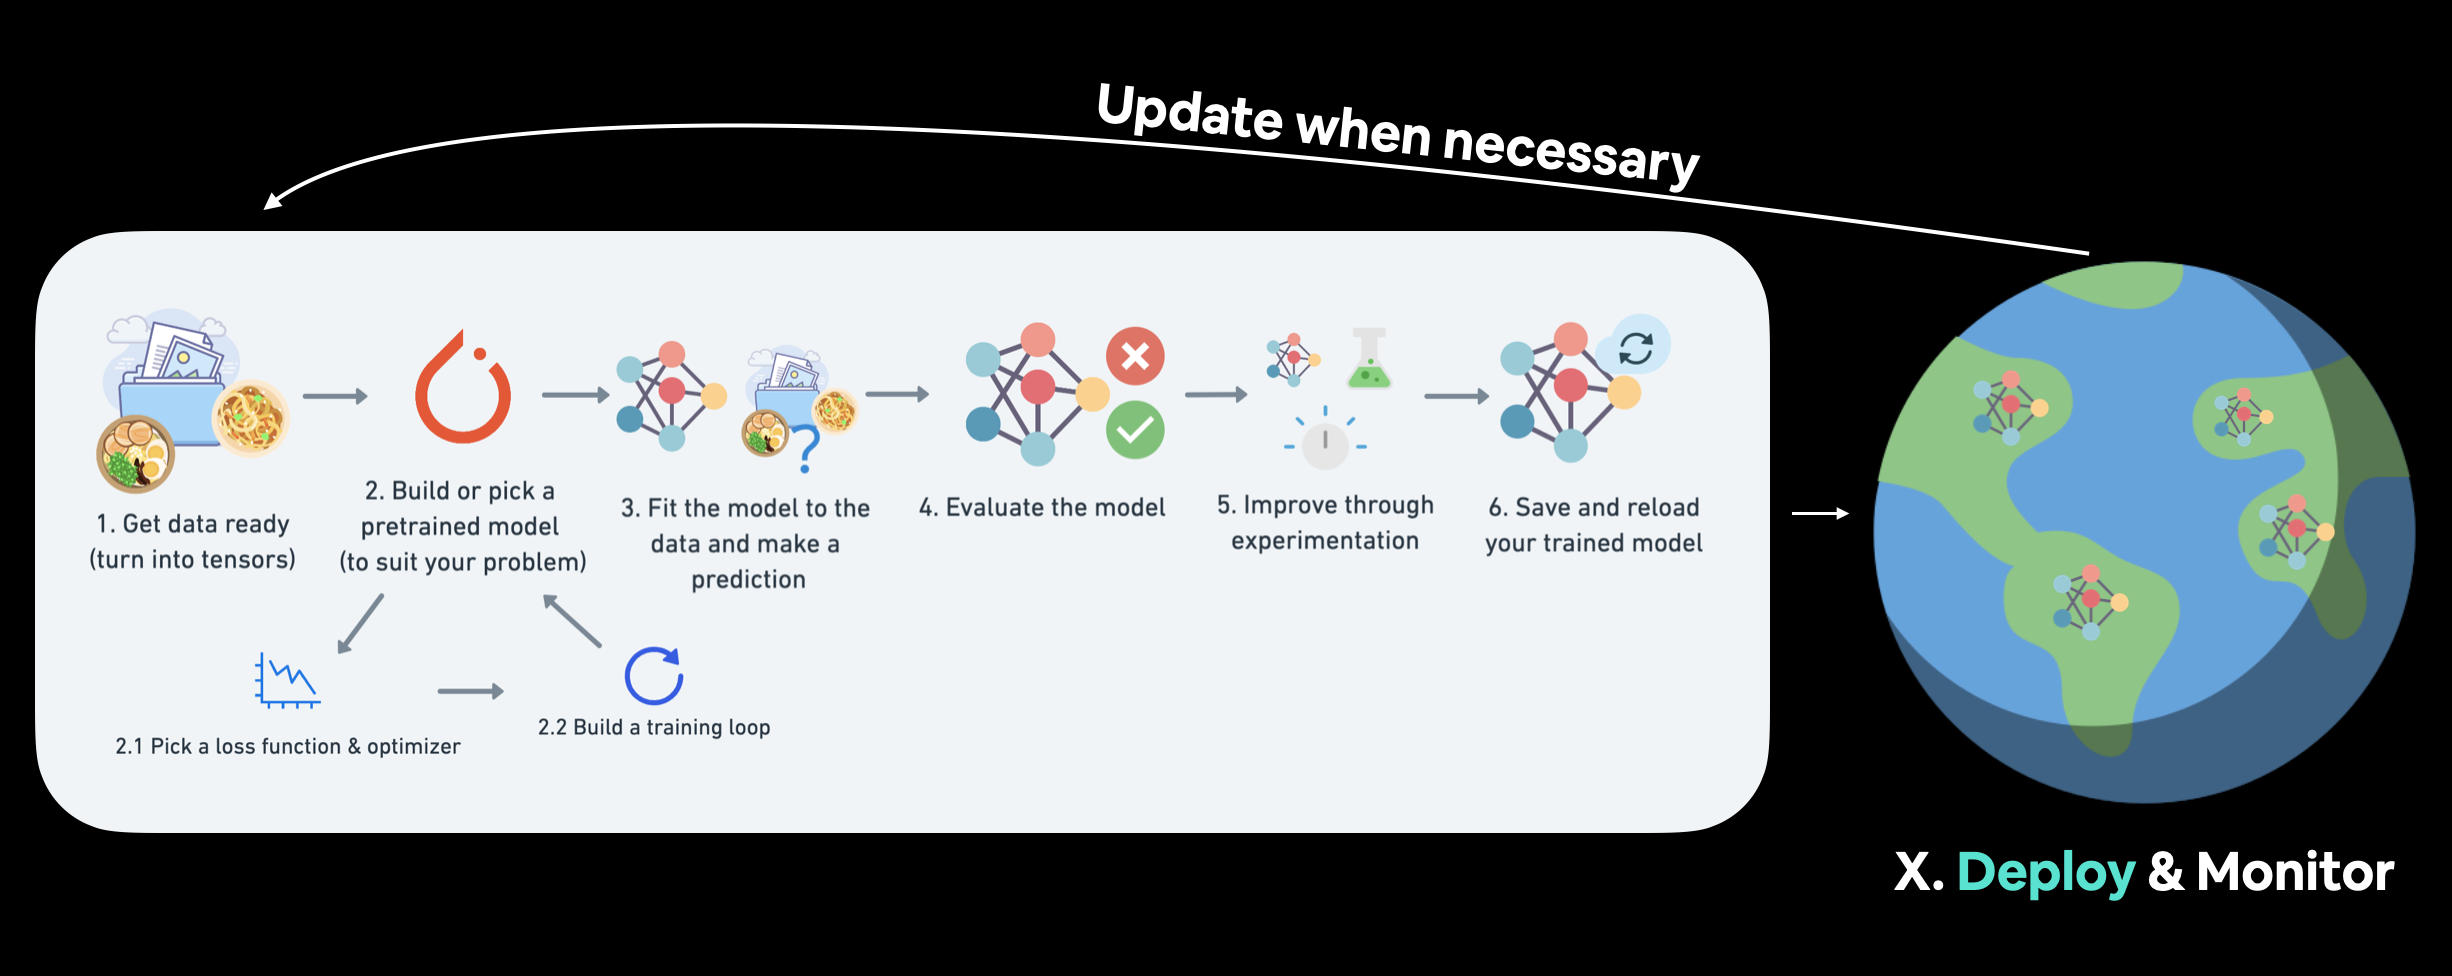

### Main Consideration while deploying the model 
1. **Where`s our model is going** 
>on device or cloud
2. **Hows my model going to perform**
> online or offline
3. **what is the ideal case for our model**
> should work evry time and inference must be fast

### Ways to deploy a machine learning model

We've discussed a couple of options for deploying machine learning models (on-device and cloud).

And each of these will have their specific requirements:

| **Tool/resource** | **Deployment type** | 
| ----- | ----- |
| [Google's ML Kit](https://developers.google.com/ml-kit) | On-device (Android and iOS) | 
| [Apple's Core ML](https://developer.apple.com/documentation/coreml) and [`coremltools` Python package](https://coremltools.readme.io/docs) | On-device (all Apple devices) | 
| [Amazon Web Service's (AWS) Sagemaker](https://aws.amazon.com/sagemaker/) | Cloud | 
| [Google Cloud's Vertex AI](https://cloud.google.com/vertex-ai) | Cloud |
| [Microsoft's Azure Machine Learning](https://azure.microsoft.com/en-au/services/machine-learning/) | Cloud |
| [Hugging Face Spaces](https://huggingface.co/spaces) | Cloud |
| API with [FastAPI](https://fastapi.tiangolo.com) | Cloud/self-hosted server |
| API with [TorchServe](https://pytorch.org/serve/) | Cloud/self-hosted server | 
| [ONNX (Open Neural Network Exchange)](https://onnx.ai/index.html) | Many/general |
| Many more... ||

> **Note:** An [application programming interface (API)](https://en.wikipedia.org/wiki/API) is a way for two (or more) computer programs to interact with each other. For example, if your model was deployed as API, you would be able to write a program that could send data to it and then receive predictions back.

Which option you choose will be highly dependent on what you're building/who you're working with.

But with so many options, it can be very intimidating.

So best to start small and keep it simple.

And one of the best ways to do so is by turning your machine learning model into a demo app with [Gradio](https://gradio.app) and then deploying it on Hugging Face Spaces.

We'll be doing just that with FoodVision Mini later on.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-tools-and-places-to-deploy-ml-models.png" alt="tools and places to deploy machine learning models" width=900/>



### 0.setting up our imports

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
torch version: 2.7.1
torchvision version: 0.22.1


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Getting the Data Ready

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

### 2. FoodVision Mini model deployment experiment outline
**Goals**: 
1. accuracy sholud be over than 95%
2. speed 0.03 seconds of inference time

#### models at hand
* `torch.models.efficientnet_b2()` 
* `torch.models.vit_b_16()`  
process experiment with these two models check their inference time and accuracy. Choose the model that will be suitable for our app and put it in prod

In [12]:
def create_effnetmodel(num_classes:int=3 , seed:int=42):
    # setting up the effiecent net b2
    effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # getting our default weights
    effnet_transforms = effnet_weights.transforms() # getting effiecent net be transforms
    effnet_model = torchvision.models.efficientnet_b2(weights=effnet_weights) # creating the model instance

    # freezing all of the model parameters
    for param in effnet_model.parameters():
        param.requires_grad =False 

    # updating the classifier head
    effnet_model.classifier = nn.Sequential(
        nn.Dropout(p=0.3,inplace=True), # keeping drop our layer true to the architecture
        nn.Linear(
            in_features =1408, # keepin in_features true to the architecture
            out_features = num_classes # changing the out features 3 cause our app classify b/w 3 classes
        )
    )
    return effnet_model,effnet_transforms

In [15]:
effnet_model , effnet_transforms = create_effnetmodel(3,42)
# effnet_model , effnet_transforms

In [14]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnet_model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [17]:
# setting up the data loaders
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnet_transforms,
                                                                                                 batch_size=32)

In [18]:
import torch

device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [19]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnet_model.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnet_model,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:26<13:01, 86.83s/it]

Epoch: 1 | train_loss: 0.9584 | train_acc: 0.5708 | test_loss: 0.7355 | test_acc: 0.9534


 20%|██        | 2/10 [02:51<11:24, 85.51s/it]

Epoch: 2 | train_loss: 0.7093 | train_acc: 0.8354 | test_loss: 0.5867 | test_acc: 0.9659


 30%|███       | 3/10 [04:16<09:55, 85.10s/it]

Epoch: 3 | train_loss: 0.5919 | train_acc: 0.8479 | test_loss: 0.4918 | test_acc: 0.9812


 40%|████      | 4/10 [05:40<08:30, 85.01s/it]

Epoch: 4 | train_loss: 0.4511 | train_acc: 0.9021 | test_loss: 0.4371 | test_acc: 0.9375


 50%|█████     | 5/10 [07:05<07:04, 84.87s/it]

Epoch: 5 | train_loss: 0.4279 | train_acc: 0.9104 | test_loss: 0.3946 | test_acc: 0.9534


 60%|██████    | 6/10 [08:30<05:39, 84.78s/it]

Epoch: 6 | train_loss: 0.4143 | train_acc: 0.8875 | test_loss: 0.3559 | test_acc: 0.9750


 70%|███████   | 7/10 [09:54<04:14, 84.73s/it]

Epoch: 7 | train_loss: 0.4188 | train_acc: 0.8417 | test_loss: 0.3290 | test_acc: 0.9597


 80%|████████  | 8/10 [11:19<02:49, 84.66s/it]

Epoch: 8 | train_loss: 0.3911 | train_acc: 0.8979 | test_loss: 0.3503 | test_acc: 0.9381


 90%|█████████ | 9/10 [12:43<01:24, 84.63s/it]

Epoch: 9 | train_loss: 0.3720 | train_acc: 0.8812 | test_loss: 0.3128 | test_acc: 0.9347


100%|██████████| 10/10 [14:08<00:00, 84.84s/it]

Epoch: 10 | train_loss: 0.3536 | train_acc: 0.8604 | test_loss: 0.2834 | test_acc: 0.9688


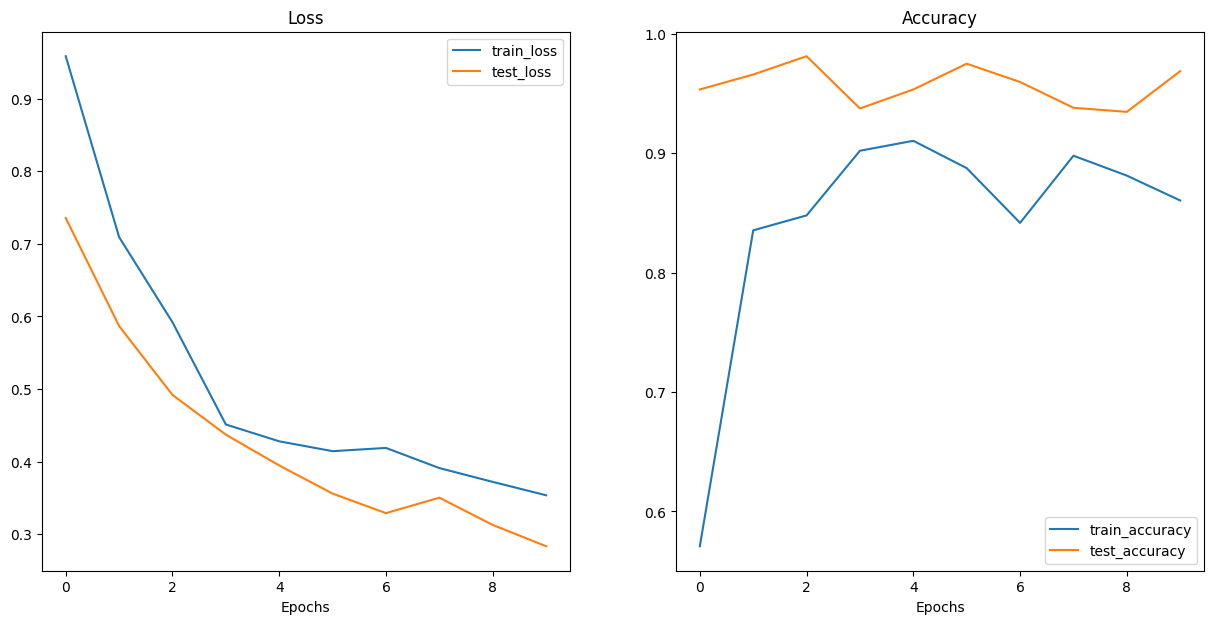

In [20]:
plot_loss_curves(effnetb2_results)

In [ ]:
# saving the model 
utils.save_model(model=effnet_model,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


###  Checking the size of EffNetB2 feature extractor

Since one of our criteria for deploying a model to power FoodVision Mini is **speed** (~30FPS or better), let's check the size of our model.

Why check the size?

Well, while not always the case, the size of a model can influence its inference speed.

As in, if a model has more parameters, it generally performs more operations and each one of these operations requires some computing power.

And because we'd like our model to work on devices with limited computing power (e.g. on a mobile device or in a web browser), generally, the smaller the size the better (as long as it still performs well in terms of accuracy).

To check our model's size in bytes, we can use Python's [`pathlib.Path.stat("path_to_model").st_size`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.stat) and then we can convert it (roughly) to megabytes by dividing it by `(1024*1024)`. 

In [23]:
from pathlib import Path

effnet_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"pretrained effnetb2 feature extractor model size : {effnet_model_size} MB")

pretrained effnetb2 feature extractor model size : 29 MB


In [25]:
# counting the praram for 29 mb model 
effnetb2_total_params = sum(torch.numel(param) for param in effnet_model.parameters())
effnetb2_total_params

7705221

In [26]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": effnet_model_size}
effnetb2_stats

{'test_loss': 0.2833980470895767,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

### lets get the stats for the VISION TRANSFORMER
`torchvision.models.vit_b_16()`

In [27]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [28]:
def create_vit_model(num_classes:int=3,seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [29]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [30]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [31]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [32]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/bhushanchowdary/Documents/GitHub/PyTorch_fundamentals/torch-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:31<13:44, 91.62s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [03:02<12:10, 91.27s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [04:33<10:36, 90.99s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [06:03<09:05, 90.87s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [07:34<07:33, 90.79s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [09:04<06:02, 90.51s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [10:35<04:31, 90.49s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [12:05<03:01, 90.59s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [13:36<01:30, 90.70s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [15:07<00:00, 90.78s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [33]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [34]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [35]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

Woah, that looks like a fair bit more than our EffNetB2!

Note: A larger number of parameters (or weights/patterns) generally means a model has a higher capacity to learn, whether it actually uses this extra capacity is another story. In light of this, our EffNetB2 model has 7,705,221 parameters where as our ViT model has 85,800,963 (11.1x more) so we could assume that our ViT model has more of a capacity to learn, if given more data (more opportunities to learn). However, this larger capacity to learn ofen comes with an increased model filesize and a longer time to perform inference.

In [36]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443448606878519,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## Making predictions with our trained models and time thier predictions

We've got a couple of trained models, both performing pretty well.

Now how about we test them out doing what we'd like them to do?

As in, let's see how they go making predictions (performing inference).

We know both of our models are performing at over 95% accuracy on the test dataset, but how fast are they?

Ideally, if we're deploying our FoodVision Mini model to a mobile device so people can take photos of their food and identify it, we'd like the predictions to happen at real-time (~30 frames per second).

That's why our second criteria is: a fast model.

To find out how long each of our models take to performance inference, let's create a function called `pred_and_store()` to iterate over each of the test dataset images one by one and perform a prediction. 

We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each element in the list is a single prediction and each sinlge prediction is a dictionary). 

> **Note:** We time the predictions one by one rather than by batch because when our model is deployed, it will likely only be making a prediction on one image at a time. As in, someone takes a photo and our model predicts on that single image.


In [37]:
from pathlib import Path

print(f"[Info] finding all the file path with '.jpg' in the directory:{test_dir} ")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[Info] finding all the file path with '.jpg' in the directory:data/pizza_steak_sushi_20_percent/test 


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

#### `pred_and_store()` algorithm(fancy way of saying our approach) for the this function
1. create the function that`ll take all the paths , a trained pytorch model a series of transformations, a list of traget classs name and a traget device.
2. create the dict to store predictions
3. loop through the input paths
4. create an empty dictorny for each iteration loop to store the prediction per sample
5. get the sample path and ground truth
6. Start the prediction timer using the pythons `timeit.default_time()`
7. open the image using `PIL.Image.open(path)`
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.


In [41]:
import pathlib
import torch 
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = 'mps' if torch.backends.mps.is_available() else 'cpu') -> List[Dict]:
    pred_list =[]
    for path in tqdm(paths):
        pred_dict = {} # empty dict
        pred_dict['image_path'] = path# for every new image path
        class_name = path.parent.stem # getting its ground label
        pred_dict['class_name'] = class_name
        start_time = timer()
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device)# transforem the image and add the batch dimension and also put that image on the target device
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image) # preform image transformations
            pred_prob = torch.softmax(pred_logit , dim=1) # turn logits into the predictions probablities across the row
            pred_label = torch.argmax(pred_prob , dim=1) # turn probablilites into the 0,1,2  across the row
            pred_class = class_names[pred_label.cpu()] # getting the strings 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            end_time =timer()
            pred_dict['time_for_pred'] = round(end_time - start_time , 4)
        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)
    return pred_list

In [42]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnet_model,
                                          transform=effnet_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 


100%|██████████| 150/150 [00:22<00:00,  6.81it/s]


In [43]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9337,
  'pred_class': 'steak',
  'time_for_pred': 0.2946,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9086,
  'pred_class': 'steak',
  'time_for_pred': 0.1458,
  'correct': True}]

In [44]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9337,steak,0.2946,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9086,steak,0.1458,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8843,steak,0.1450,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6595,steak,0.1534,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.5879,steak,0.1488,True


In [45]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [46]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1464 seconds


In [47]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2833980470895767,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.1464)}

In [48]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

100%|██████████| 150/150 [00:10<00:00, 14.80it/s]


In [49]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7962,
  'pred_class': 'steak',
  'time_for_pred': 0.479,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9981,
  'pred_class': 'steak',
  'time_for_pred': 0.0629,
  'correct': True}]

In [50]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,0.4790,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.0629,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.0624,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,0.0633,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9519,steak,0.0629,True


In [51]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [52]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.0673 seconds


In [53]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443448606878519,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.0673)}

In [54]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.283398,96.88,7705221,29,0.1464,EffNetB2
1,0.064434,98.47,85800963,327,0.0673,ViT


In [55]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.227364,1.016412,11.135432,11.275862,0.459699


| Metric              | ViT/EffNetB2 Ratio | Interpretation                                         |
| ------------------- | ------------------ | ------------------------------------------------------ |
| **Test Loss**       | 0.227              | ✅ ViT has \~**4.4x lower** test loss                   |
| **Test Accuracy**   | 1.016              | ✅ ViT has **1.6% higher** accuracy (**1.016x better**) |
| **# Parameters**    | 11.14              | ❌ ViT has **11.14x more** parameters                   |
| **Model Size (MB)** | 11.28              | ❌ ViT is **11.28x larger** in memory                   |
| **Time/pred (CPU)** | 0.459              | ✅ ViT is **\~2.18x faster** (1 / 0.459 ≈ 2.18x faster) |


even tough VIt is  bigger model its faster at cpu and more accurate so lets deply VIT

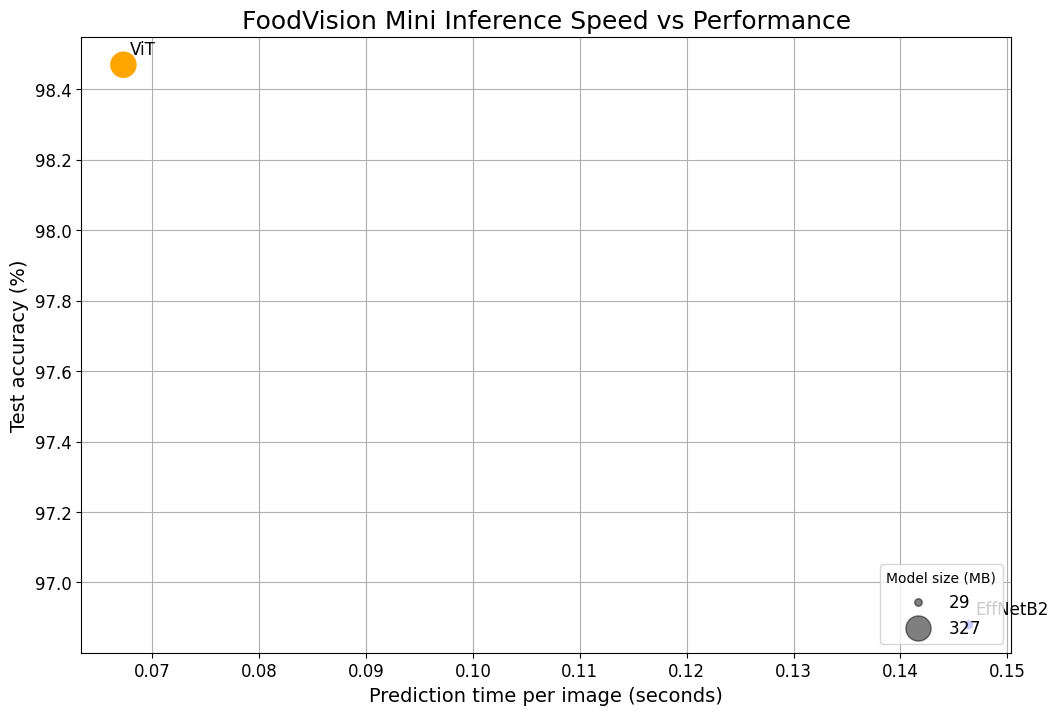

In [57]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)



# Show the figure
plt.show()

#### It is clear that VIT is the better model


In [58]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Gradio version: 5.35.0


`images of food -> VIT -> outputs`

more in depth work flow 

`input: imgaes of food -> transform -> predict VIT -> output: pred, pred prob , time take`

In [59]:
#putting the vit into cpu

vit.to("cpu")

next(iter(vit.parameters())).device

device(type='cpu')

create the `predict()` function to replicate the work flow

In [61]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict , float]:
    start_time = timer()
    img = vit_transforms(img).unsqueeze(0)
    vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

Now we have to connect the paths to the pred function


In [62]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths,k=1)[0]
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg

Prediction label and probability dictionary: 
{'pizza': 0.016353055834770203, 'steak': 0.017971096560359, 'sushi': 0.9656758904457092}
Prediction time: 0.15826 seconds


### just creating the example list to predict the examples 

In [63]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/780283.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2061929.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg']]

`gradio.Interface(examples=List[Any])` gadio interface takes the examples of as an optinal parameter

###  Building a Gradio interface

Time to put everything together and bring our FoodVision Mini demo to life!

Let's create a Gradio interface to replicate the workflow:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

We can do with the [`gradio.Interface()`](https://gradio.app/docs/#interface) class with the following parameters:
* `fn` - a Python function to map `inputs` to `outputs`, in our case, we'll use our `predict()` function.
* `inputs` - the input to our interface, such as an image using [`gradio.Image()`](https://gradio.app/docs/#image) or `"image"`. 
* `outputs` - the output of our interface once the `inputs` have gone through the `fn`, such as a label using [`gradio.Label()`](https://gradio.app/docs/#label) (for our model's predicted labels) or number using [`gradio.Number()`](https://gradio.app/docs/#number) (for our model's prediction time).
    * **Note:** Gradio comes with many in-built `inputs` and `outputs` options known as ["Components"](https://gradio.app/docs/#components).
* `examples` - a list of examples to showcase for the demo.
* `title` - a string title of the demo.
* `description` - a string description of the demo.
* `article` - a reference note at the bottom of the demo.


In [64]:
import gradio as gr
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An VISION TRANSFORMER feature extractor computer vision model to classify images of food as pizza, steak or sushi."
# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description
                    )
# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://ed07e5876ed1e8cb6a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Turning our FOodvision mini  demo into a deplyble app
### 8.2 Deployed Gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Where:
* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our Gradio app (similar to the code that launched the app).
    * **Note:** `app.py` is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called `app.py` to run. This is changeable in settings.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model definition as well as any transforms associated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

Why this way?

Because it's one of the simplest layouts we could begin with. 

Our focus is: *experiment, experiment, experiment!* 

The quicker we can run smaller experiments, the better our bigger ones will be.



In [65]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, 
                                exist_ok=True)
    
# Check what's in the folder
!ls demos/foodvision_mini/

In [66]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [67]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

In [68]:
import shutil

# Create a source path for our target model
vit_foodvision_mini_model_path = "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
vit_foodvision_mini_model_destination = foodvision_mini_demo_path / vit_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {vit_foodvision_mini_model_path} to {vit_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=vit_foodvision_mini_model_path, 
                dst=vit_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {vit_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {vit_foodvision_mini_model_destination}: {vit_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [69]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_vit_model(num_classes:int=3,seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [70]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
vit, vit_transforms = create_vit_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
vit.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [71]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


In [72]:
!ls demos/foodvision_mini

09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [74]:
import zipfile
import os

# Define the folder to zip
folder_to_zip = "demos/foodvision_mini"
output_zip_path = "foodvision_mini.zip"

# Create a zip file excluding specific patterns
with zipfile.ZipFile(output_zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        # Skip unwanted directories
        if "__pycache__" in root or "ipynb_checkpoints" in root:
            continue
        for file in files:
            if file.endswith(".pyc") or file.endswith(".ipynb"):
                continue
            full_path = os.path.join(root, file)
            relative_path = os.path.relpath(full_path, folder_to_zip)
            zipf.write(full_path, arcname=relative_path)

print(f"Zipped successfully: {output_zip_path}")


Zipped successfully: foodvision_mini.zip
